# Real-time Unsupervised Anomaly Detection

## Installation of AnomaLib

In [ ]:
!pip install matplotlib==3.1.3 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 32.4 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3


In [ ]:
!ls

dataset    unsupervised-anomaly-detection.html
README.md  unsupervised-anomaly-detection.ipynb


In [ ]:
!git clone https://github.com/openvinotoolkit/anomalib.git

Cloning into 'anomalib'...
remote: Enumerating objects: 23179, done.
remote: Counting objects: 100% (926/926), done.
remote: Compressing objects: 100% (426/426), done.
remote: Total 23179 (delta 554), reused 810 (delta 486), pack-reused 22253
Receiving objects: 100% (23179/23179), 53.66 MiB | 16.05 MiB/s, done.
Resolving deltas: 100% (13822/13822), done.


In [ ]:
%cd anomalib

/content/anomalib


In [ ]:
!ls

anomalib	    CONTRIBUTING.md  notebooks	     tests
CHANGELOG.md	    docs	     pyproject.toml  third-party-programs.txt
CITATION.cff	    LICENSE	     README.md	     tools
CODE_OF_CONDUCT.md  MANIFEST.in      requirements    tox.ini
configs		    markdownlint.rb  setup.py


In [ ]:
!pip install -e . -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 11.2 MB 59.8 MB/s 
     |████████████████████████████████| 1.8 MB 55.7 MB/s 
     |████████████████████████████████| 19.1 MB 1.1 MB/s 
     |████████████████████████████████| 419 kB 72.6 MB/s 
     |████████████████████████████████| 412 kB 65.6 MB/s 
     |████████████████████████████████| 159 kB 76.2 MB/s 
     |████████████████████████████████| 551 kB 73.5 MB/s 
     |████████████████████████████████| 79 kB 8.7 MB/s 
     |████████████████████████████████| 585 kB 68.7 MB/s 
     |████████████████████████████████| 1.9 MB 54.7 MB/s 
     |████████████████████████████████| 431 kB 72.5 MB/s 
     |████████████████████████████████| 5.3 MB 68.1 MB/s 
     |████████████████████████████████| 182 kB 66.0 MB/s 
     |████████████████████████████████| 166 kB 76.5 MB/s 
     |████████████████████████████████| 54 kB 3.3 MB/s 
     |█

In [ ]:
import anomalib
anomalib.__version__

'0.3.6'

In [ ]:
%cd ..

/content


In [ ]:
!ls

anomalib  sample_data


In [ ]:
!curl --help

Usage: curl [options...] <url>
     --abstract-unix-socket <path> Connect via abstract Unix domain socket
     --anyauth       Pick any authentication method
 -a, --append        Append to target file when uploading
     --basic         Use HTTP Basic Authentication
     --cacert <file> CA certificate to verify peer against
     --capath <dir>  CA directory to verify peer against
 -E, --cert <certificate[:password]> Client certificate file and password
     --cert-status   Verify the status of the server certificate
     --cert-type <type> Certificate file type (DER/PEM/ENG)
     --ciphers <list of ciphers> SSL ciphers to use
     --compressed    Request compressed response
     --compressed-ssh Enable SSH compression
 -K, --config <file> Read config from a file
     --connect-timeout <seconds> Maximum time allowed for connection
     --connect-to <HOST1:PORT1:HOST2:PORT2> Connect to host
 -C, --continue-at <offset> Resumed transfer offset
 -b, --cookie <data> Send cookies from string/

In [ ]:
! curl https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937637-1629952063/metal_nut.tar.xz --output metal_nut.tar.xz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  157M  100  157M    0     0  8755k      0  0:00:18  0:00:18 --:--:-- 10.4M


In [ ]:
!tar xf metal_nut.tar.xz

## Import libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os, pprint, yaml, warnings, math, glob, cv2, random, logging
from IPython.display import Image

In [ ]:
def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings('ignore')
logger = logging.getLogger("anomalib")

In [ ]:
import anomalib
from pytorch_lightning import Trainer, seed_everything
from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.models import get_model
from anomalib.utils.callbacks import LoadModelCallback, get_callbacks
from anomalib.utils.loggers import configure_logger, get_experiment_logger

In [ ]:
import torch
print("Torch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("GPU availability:", torch.cuda.is_available())
print("Number of GPU devices:", torch.cuda.device_count())      
print("Name of current GPU:", torch.cuda.get_device_name(0))  

Torch version: 1.12.0+cu102
CUDA version: 10.2
GPU availability: True
Number of GPU devices: 1
Name of current GPU: Tesla T4


## Dataset Exploration

In [ ]:
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)

In [ ]:
!ls

anomalib  metal_nut  metal_nut.tar.xz  sample_data


In [ ]:
list_files("metal_nut")

metal_nut/
    test/
        good/
        scratch/
        flip/
        color/
        bent/
    train/
        good/
    ground_truth/
        scratch/
        flip/
        color/
        bent/


## Models

## Configuration

In [ ]:
%cd {'/content'}

/content


In [ ]:
!ls

anomalib  metal_nut  metal_nut.tar.xz  sample_data


In [ ]:
CONFIG_PATHS = '/content' + '/anomalib/anomalib/models'
MODEL_CONFIG_PAIRS = {
    'patchcore': f'{CONFIG_PATHS}/patchcore/config.yaml',
    'padim':     f'{CONFIG_PATHS}/padim/config.yaml',
    'cflow':     f'{CONFIG_PATHS}/cflow/config.yaml',
    'dfkde':     f'{CONFIG_PATHS}/dfkde/config.yaml',
    'dfm':       f'{CONFIG_PATHS}/dfm/config.yaml',
    'ganomaly':  f'{CONFIG_PATHS}/ganomaly/config.yaml',
    'stfpm':     f'{CONFIG_PATHS}/stfpm/config.yaml',
    'fastflow':  f'{CONFIG_PATHS}/fastflow/config.yaml',
    'draem':     f'{CONFIG_PATHS}/draem/config.yaml',
    'reverse_distillation': f'{CONFIG_PATHS}/reverse_distillation/config.yaml',
}

In [ ]:
MODEL = 'reverse_distillation'
print(open(os.path.join(MODEL_CONFIG_PAIRS[MODEL]), 'r').read())

dataset:
  name: mvtec #options: [mvtec, btech, folder]
  format: mvtec
  path: ./datasets/MVTec
  category: bottle
  task: segmentation
  image_size: 256
  train_batch_size: 32
  test_batch_size: 32
  inference_batch_size: 32
  num_workers: 8
  transform_config:
    train: null
    val: null
  create_validation_set: false
  tiling:
    apply: false
    tile_size: 64
    stride: null
    remove_border_count: 0
    use_random_tiling: False
    random_tile_count: 16

model:
  name: reverse_distillation
  lr: 0.005
  backbone: wide_resnet50_2
  pre_trained: true
  layers:
    - layer1
    - layer2
    - layer3
  early_stopping:
    patience: 3
    metric: pixel_AUROC
    mode: max
  beta1: 0.5
  beta2: 0.99
  normalization_method: min_max # options: [null, min_max, cdf]
  anomaly_map_mode: multiply

metrics:
  image:
    - F1Score
    - AUROC
  pixel:
    - F1Score
    - AUROC
  threshold:
    method: adaptive #options: [adaptive, manual]
    manual_image: null
    manual_pixel: null

vis

In [ ]:
new_update = {
    "path": '/content',
    'task': 'segmentation',
    'category': 'metal_nut', 
    'image_size': 256,
    'train_batch_size': 4,
    'test_batch_size': 4,
    'max_epochs': 4,
    'seed': 101
}

In [ ]:
def update_yaml(old_yaml, new_yaml, new_update):
    with open(old_yaml) as f:
        old = yaml.safe_load(f)
                  
    temp = []
    def set_state(old, key, value):
        if isinstance(old, dict):
            for k, v in old.items():
                if k == 'project':
                    temp.append(k)
                if k == key:
                    if temp and k == 'path':
                        continue
                    old[k] = value
                elif isinstance(v, dict):
                    set_state(v, key, value)
    
    for key, value in new_update.items():
        set_state(old, key, value)


    with open(new_yaml, 'w') as f:
        yaml.safe_dump(old, f, default_flow_style=False)

In [ ]:
new_yaml_path = CONFIG_PATHS + '/' + MODEL + '_new.yaml'

In [ ]:
new_yaml_path

'/content/anomalib/anomalib/models/reverse_distillation_new.yaml'

In [ ]:
update_yaml(MODEL_CONFIG_PAIRS[MODEL], new_yaml_path, new_update)        

In [ ]:
with open(new_yaml_path) as f:
    updated_config = yaml.safe_load(f)
pprint.pprint(updated_config)

{'dataset': {'category': 'metal_nut',
             'create_validation_set': False,
             'format': 'mvtec',
             'image_size': 256,
             'inference_batch_size': 32,
             'name': 'mvtec',
             'num_workers': 8,
             'path': '/content',
             'task': 'segmentation',
             'test_batch_size': 4,
             'tiling': {'apply': False,
                        'random_tile_count': 16,
                        'remove_border_count': 0,
                        'stride': None,
                        'tile_size': 64,
                        'use_random_tiling': False},
             'train_batch_size': 4,
             'transform_config': {'train': None, 'val': None}},
 'logging': {'log_graph': False, 'logger': []},
 'metrics': {'image': ['F1Score', 'AUROC'],
             'pixel': ['F1Score', 'AUROC'],
             'threshold': {'manual_image': None,
                           'manual_pixel': None,
                           'method': 'a

##  Training

In [ ]:
if updated_config['project']['seed'] != 0:
    print(updated_config['project']['seed'])
    seed_everything(updated_config['project']['seed'])

INFO:pytorch_lightning.utilities.seed:Global seed set to 101


101


In [ ]:
config = get_configurable_parameters(
    model_name=updated_config['model']['name'],
    config_path=new_yaml_path
)

In [ ]:
model      = get_model(config)
experiment_logger = get_experiment_logger(config)
callbacks  = get_callbacks(config)
datamodule = get_datamodule(config)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/wide_resnet50_racm-8234f177.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_racm-8234f177.pth


In [ ]:
trainer = Trainer(**config.trainer, logger=experiment_logger, callbacks=callbacks)
trainer.fit(model=model, datamodule=datamodule)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Evaluation

In [ ]:
load_model_callback = LoadModelCallback(
    weights_path=trainer.checkpoint_callback.best_model_path
)
trainer.callbacks.insert(0, load_model_callback)
trainer.test(model=model, datamodule=datamodule)

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       image_AUROC          0.5547409057617188
      image_F1Score         0.8942307829856873
       pixel_AUROC          0.9728915691375732
      pixel_F1Score         0.8017448782920837
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'pixel_F1Score': 0.8017448782920837,
  'pixel_AUROC': 0.9728915691375732,
  'image_F1Score': 0.8942307829856873,
  'image_AUROC': 0.5547409057617188}]

## Visualization

In [ ]:
RESULT_PATH = os.path.join(
    updated_config['project']['path'],
    updated_config['model']['name'],
    updated_config['dataset']['format'], 
    updated_config['dataset']['category']
)
RESULT_PATH

'./results/reverse_distillation/mvtec/metal_nut'

In [ ]:
def visualiz(paths, n_images, is_random=True, figsize=(16, 16)):
    for i in range(n_images):
        image_name = paths[i]
        if is_random: image_name = random.choice(paths)
        img = cv2.imread(image_name)[:,:,::-1]
        
        category_type = image_name.split('/')[-4:-3:][0]
        defected_type = image_name.split('/')[-2:-1:][0]
        
        plt.figure(figsize=figsize)
        plt.imshow(img)
        plt.title(
            f"Category : {category_type} and Defected Type : {defected_type} \n {image_name}", 
            fontdict={'fontsize': 20, 'fontweight': 'medium'}
        )
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
    plt.show()

In [ ]:
for content in os.listdir(RESULT_PATH):
    if content == 'images':
        full_path = glob.glob(os.path.join(RESULT_PATH, content, '**',  '*.png'), recursive=True)
        print('Total Image ', len(full_path))
        print(full_path[0].split('/'))
        print(full_path[0].split('/')[-2:-1:])
        print(full_path[0].split('/')[-4:-3:])

Total Image  117
['.', 'results', 'reverse_distillation', 'mvtec', 'metal_nut', 'images', 'image_ROC.png']
['images']
['mvtec']


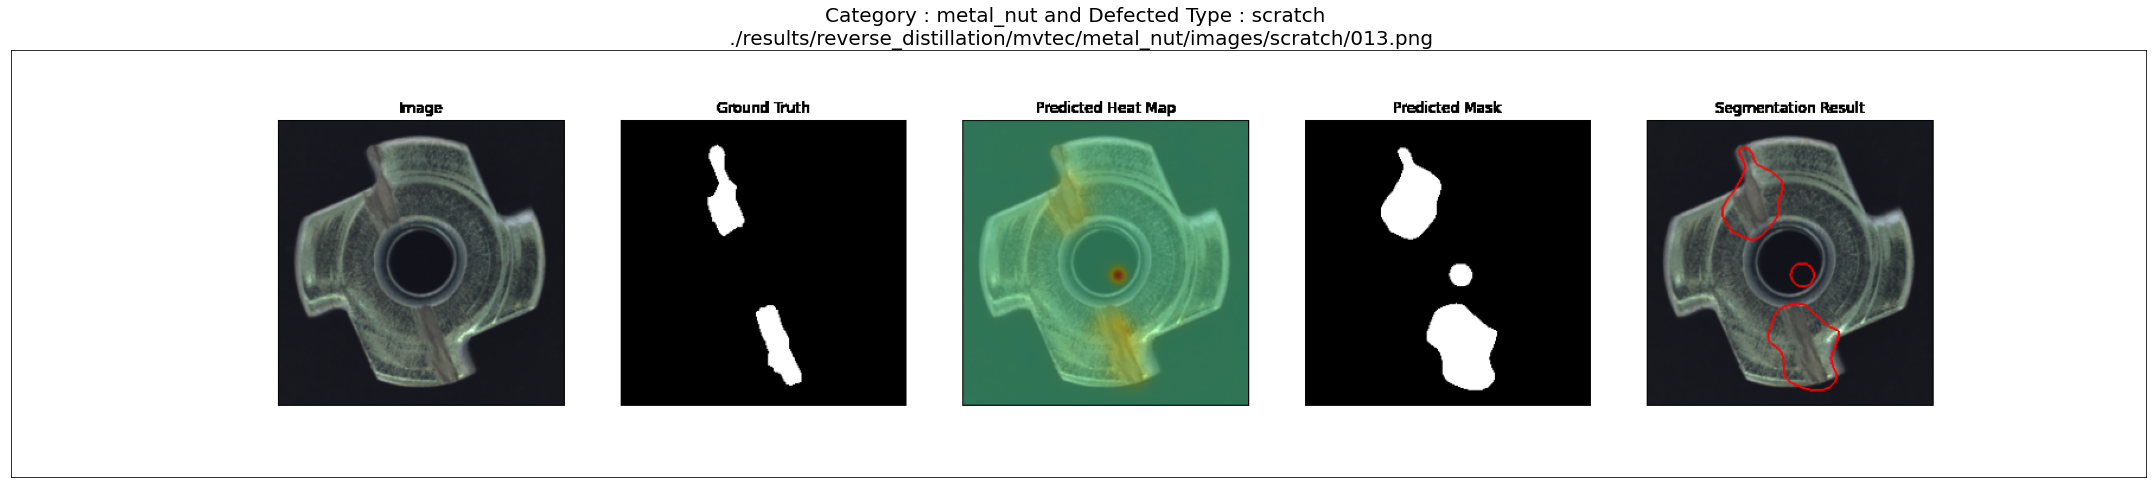

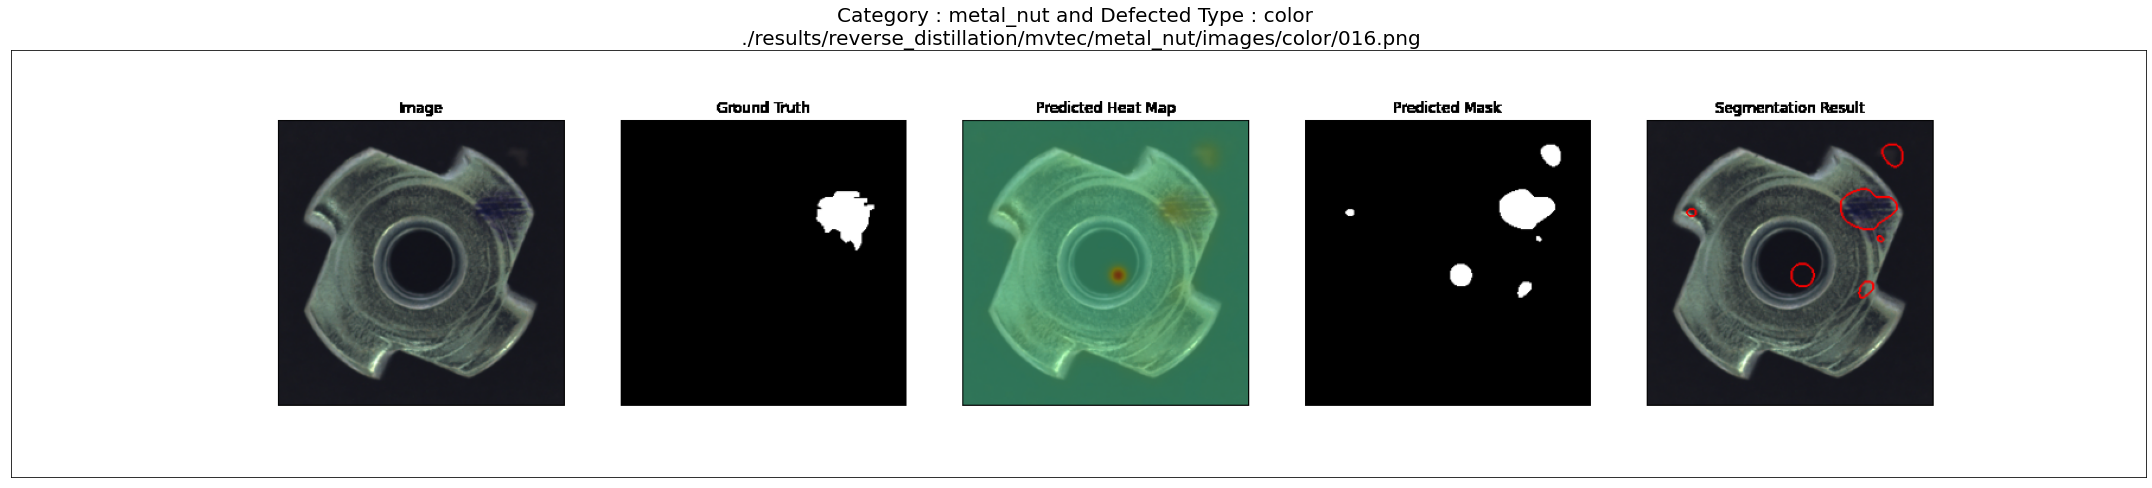

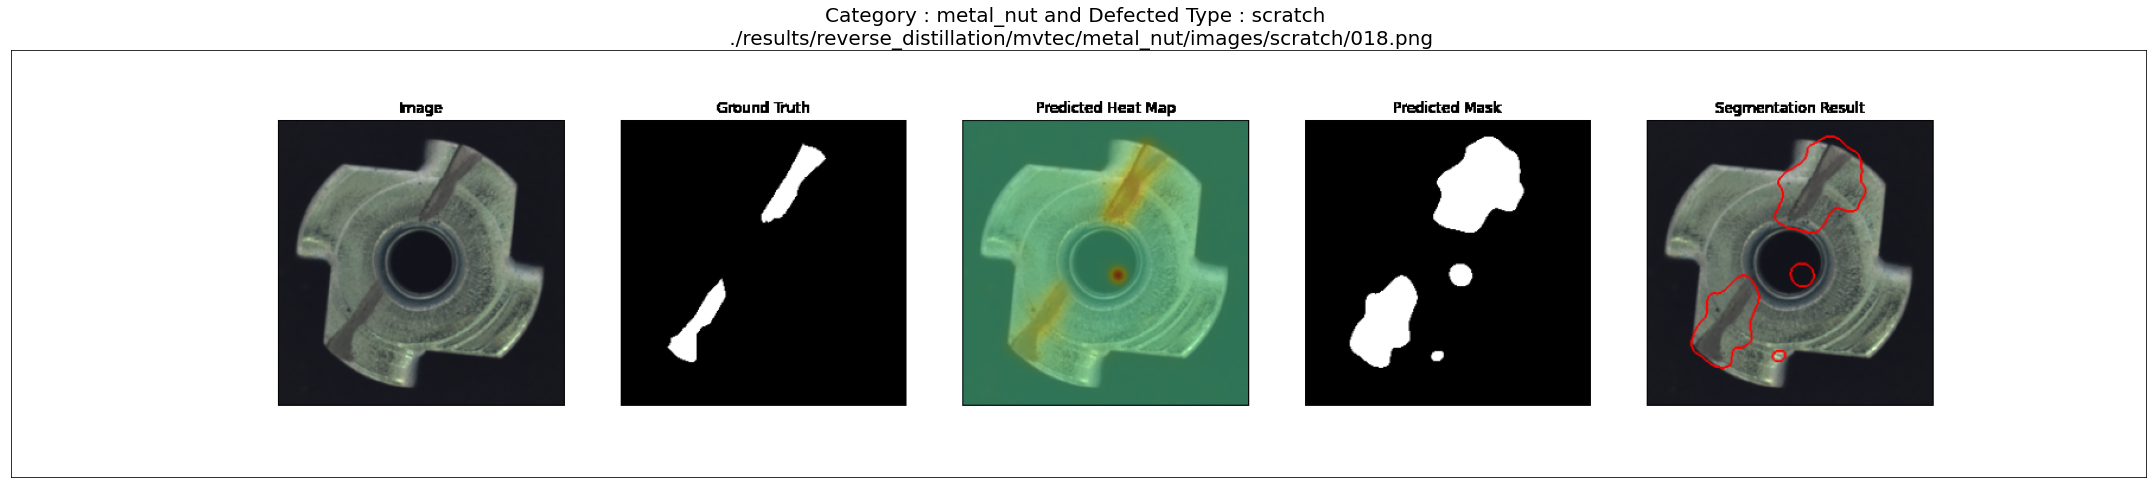

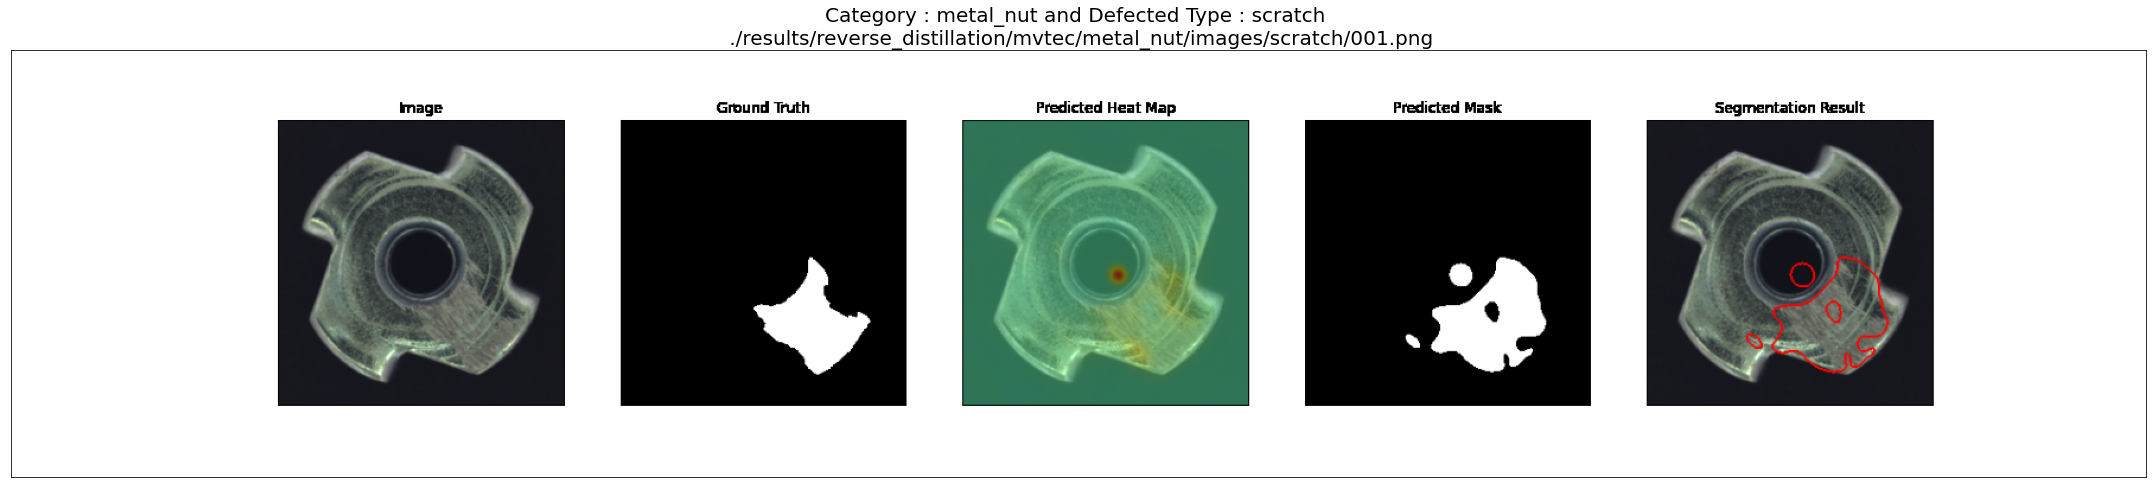

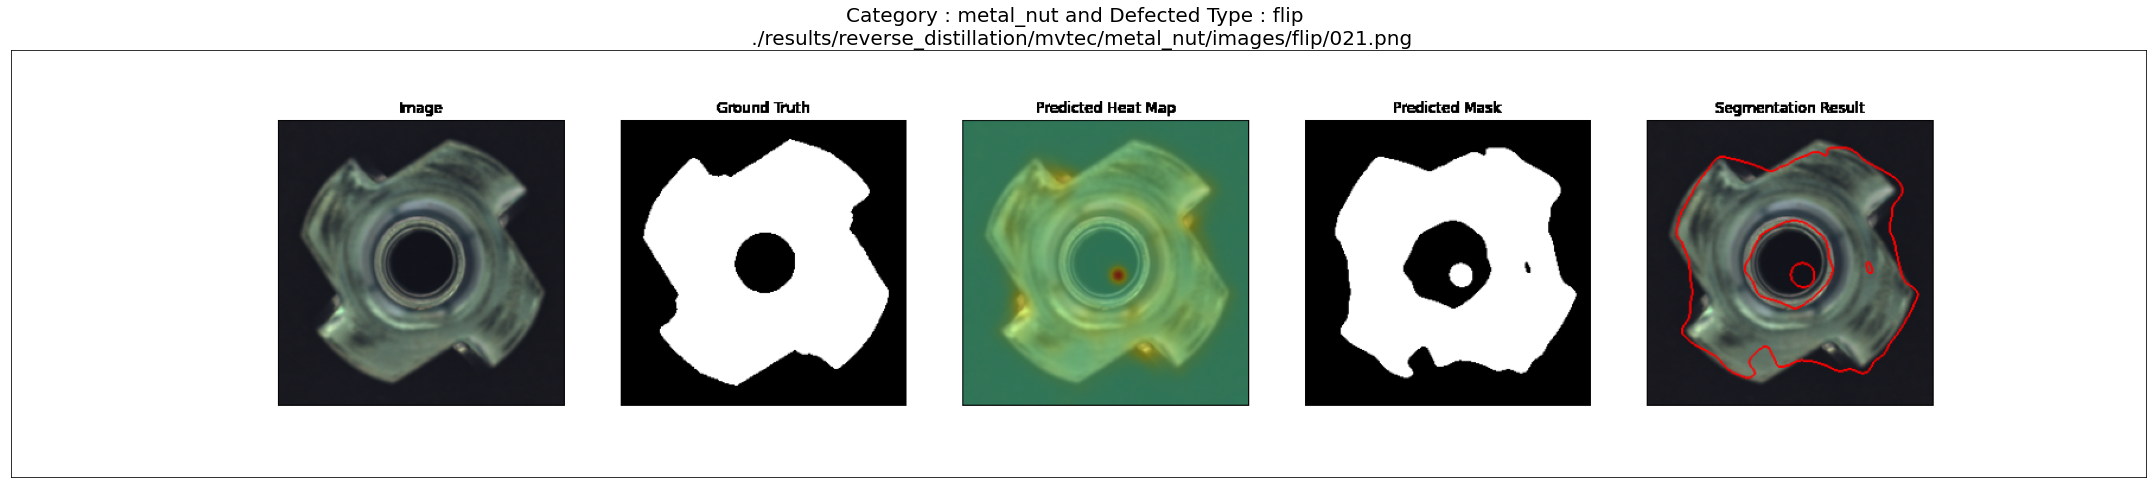

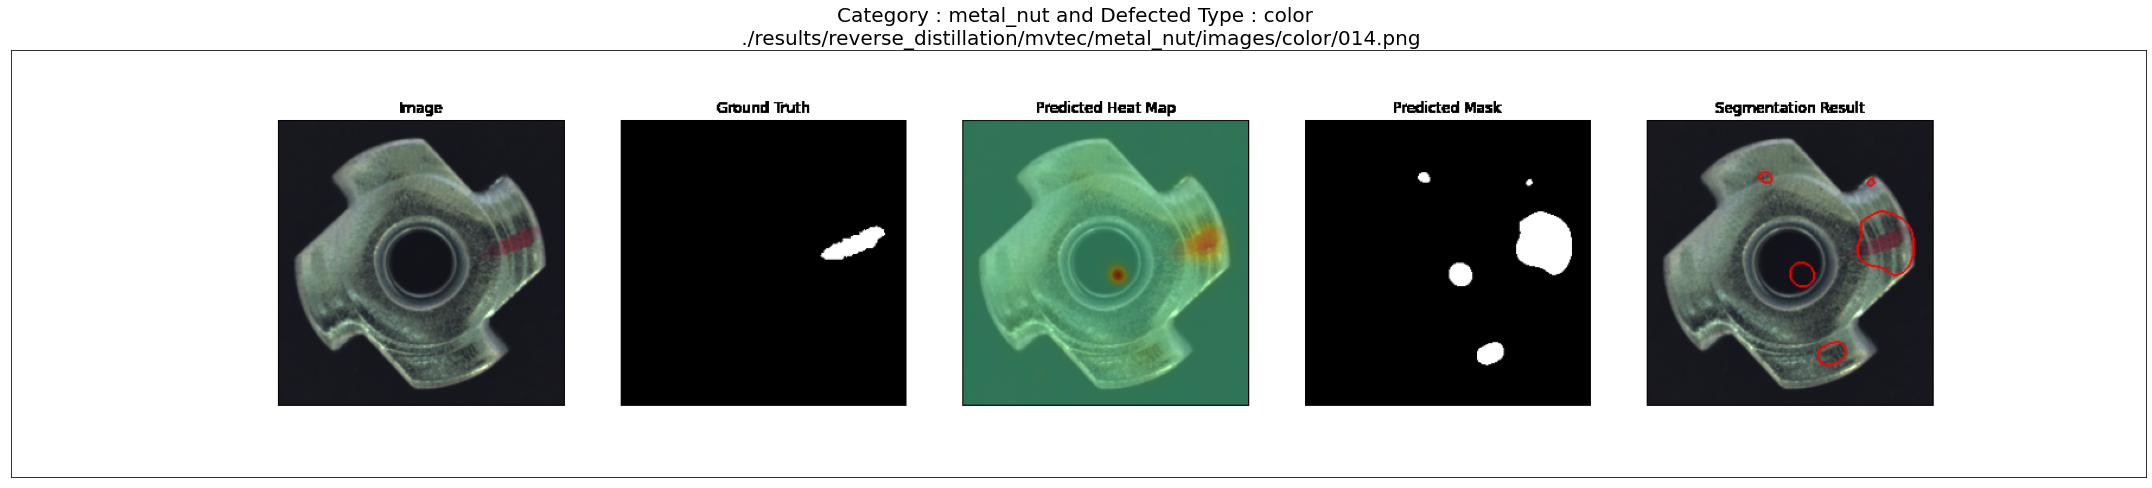

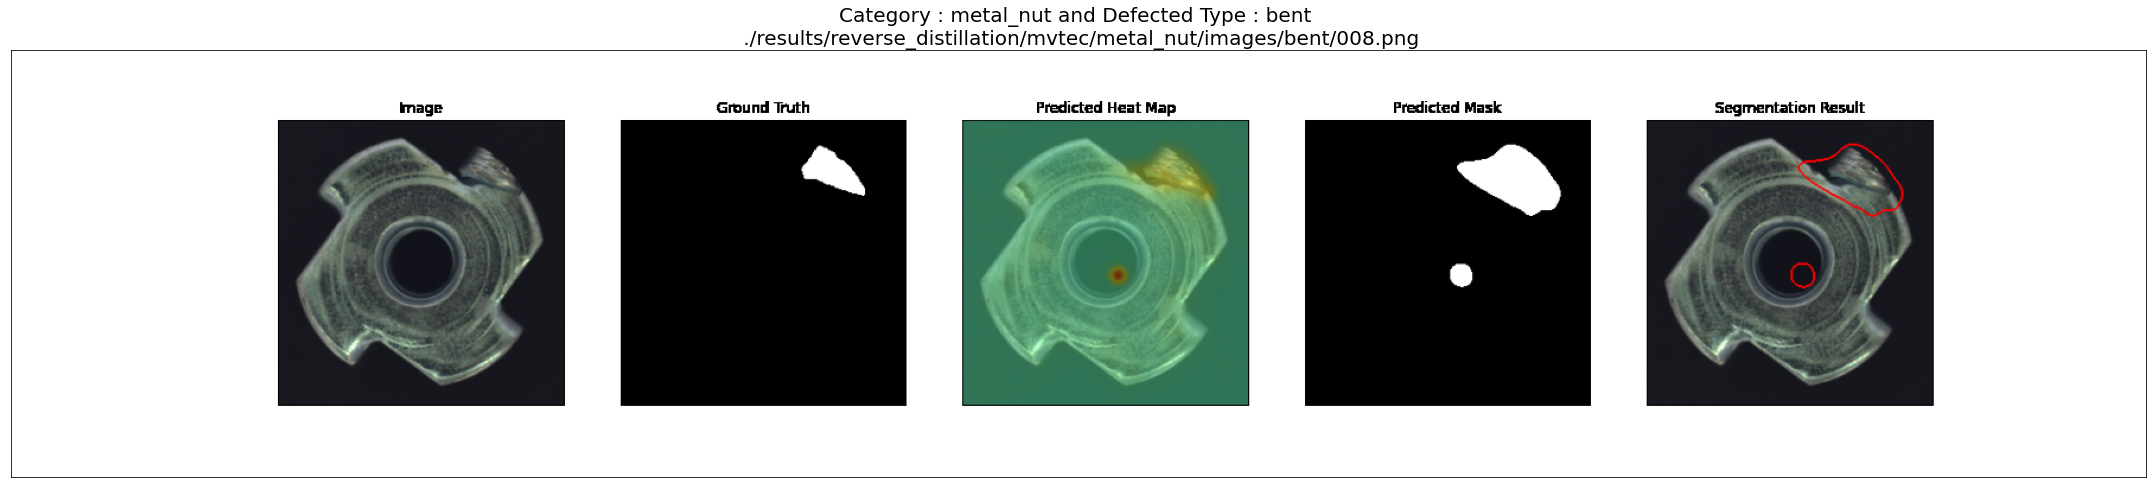

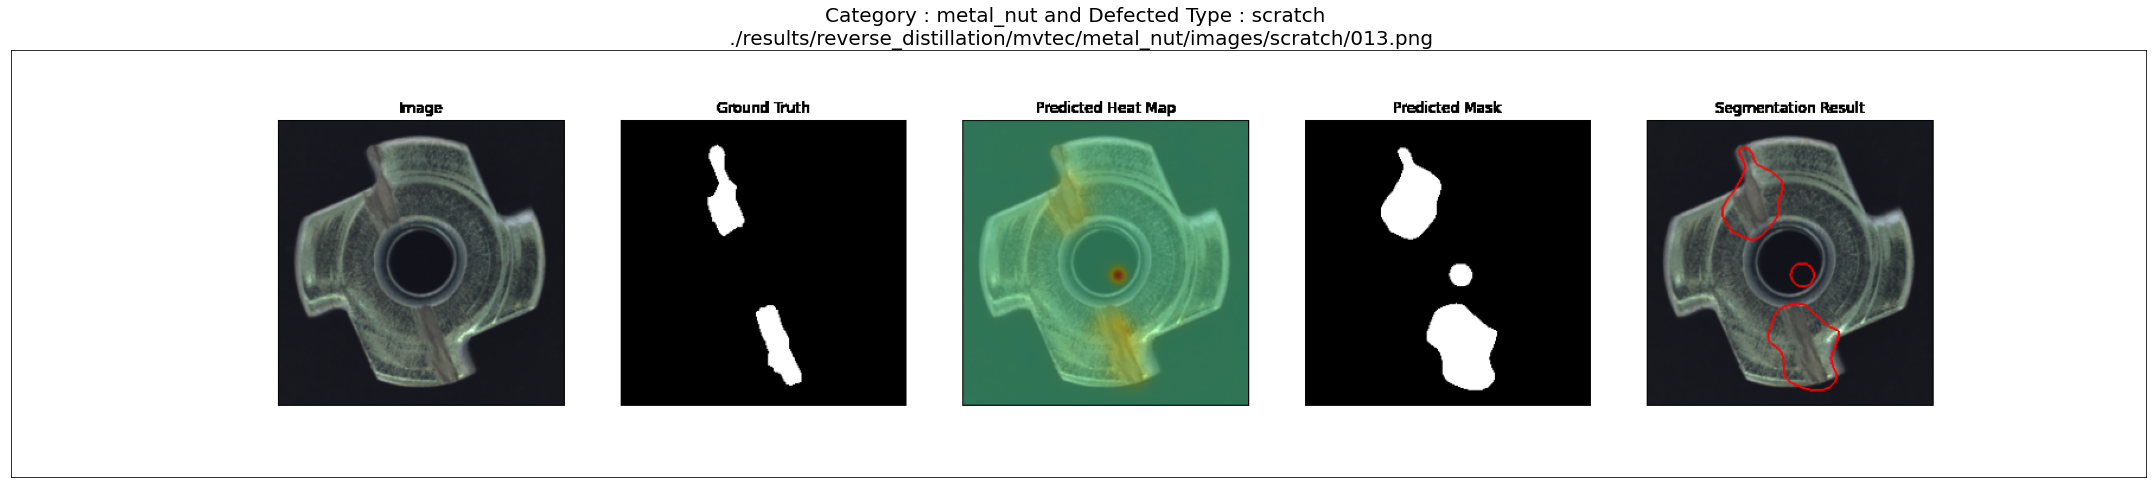

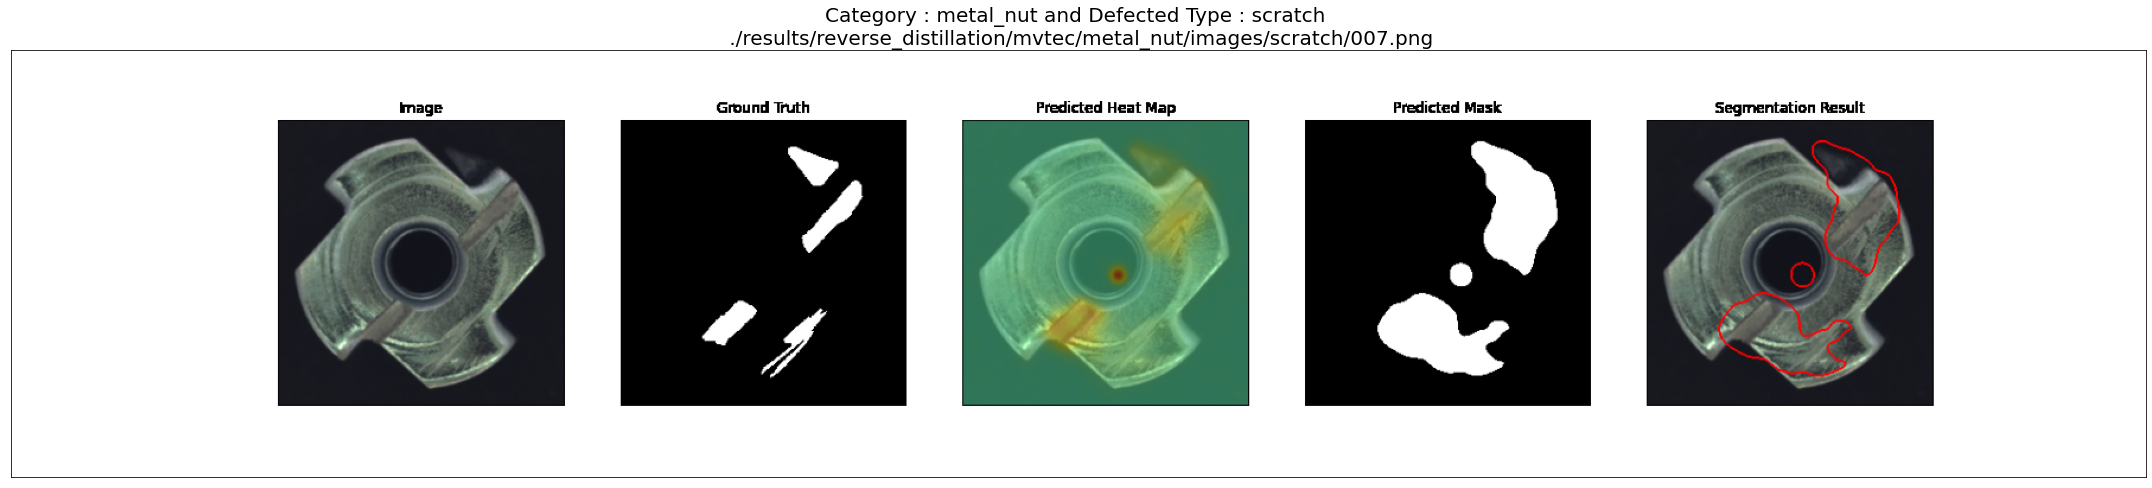

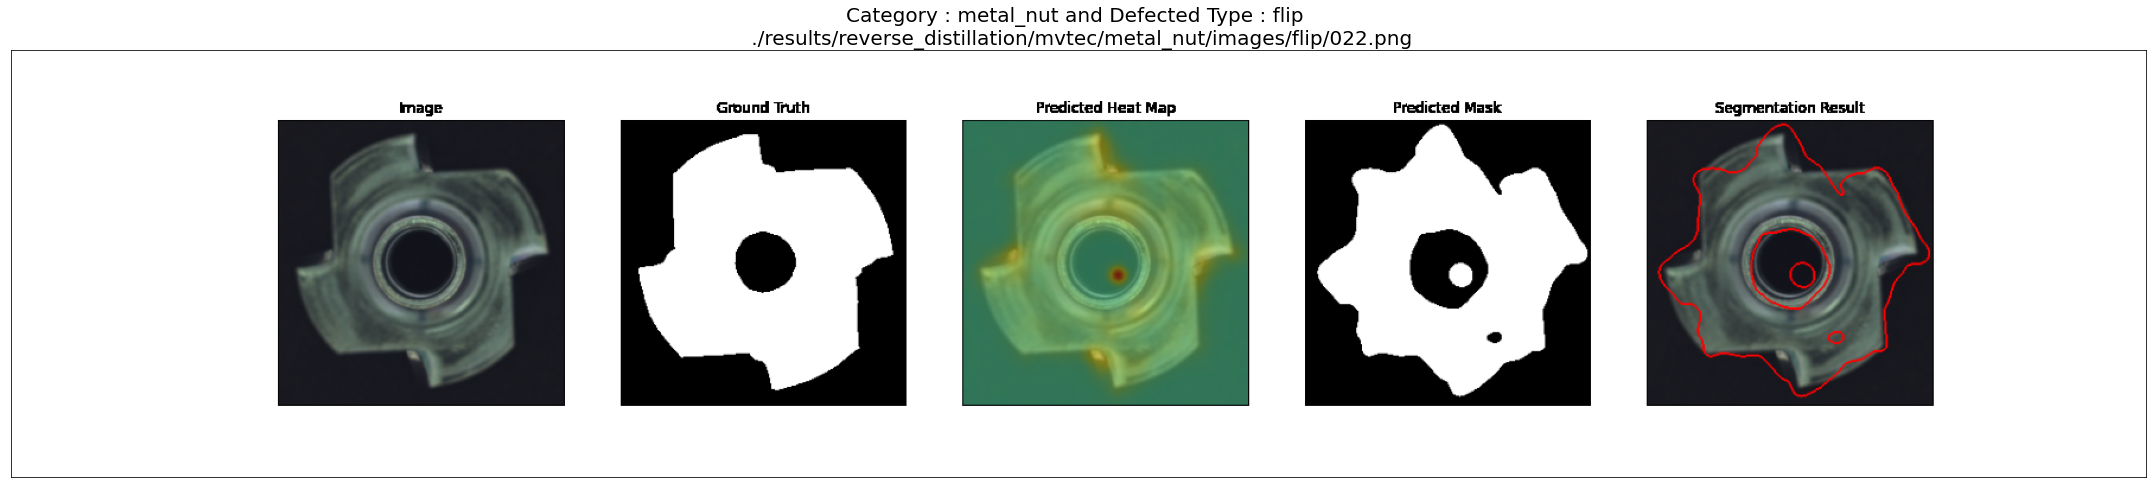

In [ ]:
visualiz(full_path, 10, is_random=True, figsize=(30, 30))

## Inference

In [ ]:
PROJECT_PATH = "/content"

In [ ]:
%cd {PROJECT_PATH}

/content


In [ ]:
!ls

anomalib  metal_nut  metal_nut.tar.xz  results	sample_data


In [ ]:
infer_results = PROJECT_PATH + "/infer_results"
infer_results

'/content/infer_results'

In [ ]:
input_img = PROJECT_PATH + "/metal_nut/test/bent/013.png"
input_img

'/content/metal_nut/test/bent/013.png'

In [ ]:
output_img = infer_results +  "/metal_nut/test/bent/013.png"
output_img

'/content/infer_results/metal_nut/test/bent/013.png'

In [ ]:
from anomalib.config import get_configurable_parameters
from anomalib.data.inference import InferenceDataset
from anomalib.models import get_model
from anomalib.utils.callbacks import get_callbacks

In [ ]:
from argparse import ArgumentParser, Namespace
from pathlib import Path

from pytorch_lightning import Trainer
from torch.utils.data import DataLoader

In [ ]:
trainer

In [ ]:
def infer(trainer):
    """Run inference."""

    config = get_configurable_parameters(config_path=new_yaml_path)
    config.trainer.resume_from_checkpoint = str(trainer.checkpoint_callback.best_model_path)
   
    config.visualization.mode = "simple"
    if infer_results:  
        config.visualization.save_images = True
        config.visualization.image_save_path = infer_results
    else:
        config.visualization.save_images = False

    model = get_model(config)
    callbacks = get_callbacks(config)

    trainer = Trainer(callbacks=callbacks, **config.trainer)

    transform_config = config.dataset.transform_config.val if "transform_config" in config.dataset.keys() else None
    dataset = InferenceDataset(
        input_img, image_size=tuple(config.dataset.image_size), transform_config=transform_config
    )
    dataloader = DataLoader(dataset)
    trainer.predict(model=model, dataloaders=[dataloader])

In [ ]:
infer(trainer)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


Predicting: 0it [00:00, ?it/s]

/content/metal_nut/test/bent/013.png


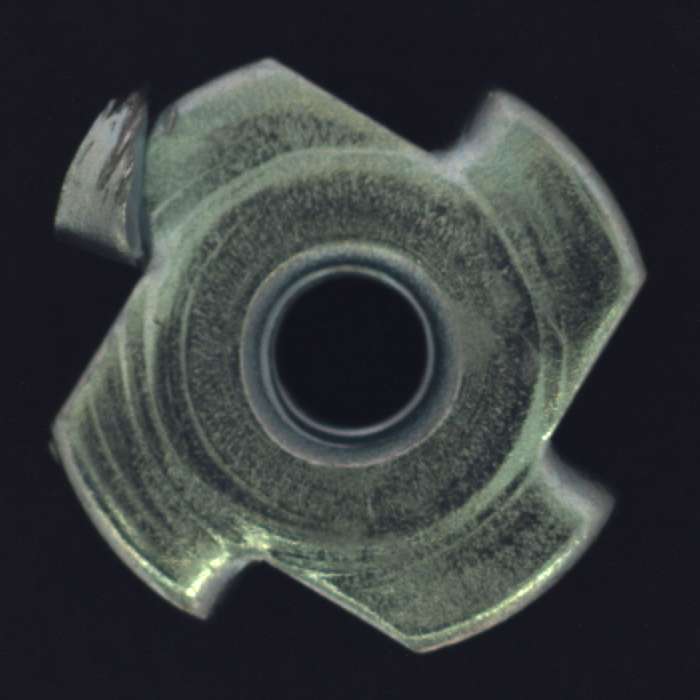

In [ ]:
print(input_img)
display(Image(input_img, width=250))

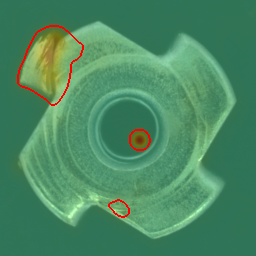

In [ ]:
display(Image("/content/infer_results/bent/013.png", width=250))

## Summary


```
MODEL = 'padim'
```

```
'image_size': 256,
'train_batch_size': 4,
'test_batch_size': 4,
'max_epochs': 4,
```

```
[{'pixel_F1Score': 0.7553240060806274,
  'pixel_AUROC': 0.9686623215675354,
  'image_F1Score': 0.952380895614624,
  'image_AUROC': 0.9496578574180603}]
```

```
MODEL = 'patchcore'
```

```
'image_size': 128,
'train_batch_size': 1,
'test_batch_size': 1,
'max_epochs': 3,
```

```
[{'pixel_F1Score': 0.8109800219535828,
  'pixel_AUROC': 0.9827464818954468,
  'image_F1Score': 0.9726775884628296,
  'image_AUROC': 0.9833822250366211}]
```

```
MODEL = 'stfpm'
```

```
'image_size': 256,
'train_batch_size': 4,
'test_batch_size': 4,
'max_epochs': 4,
```

```
[{'pixel_F1Score': 0.6699215769767761,
  'pixel_AUROC': 0.9740051627159119,
  'image_F1Score': 0.9555555582046509,
  'image_AUROC': 0.9838709235191345}]
```

```
MODEL = 'fastflow'
```

```
'image_size': 256,
'train_batch_size': 4,
'test_batch_size': 4,
'max_epochs': 4,
```

```
[{'pixel_F1Score': 0.7417428493499756,
  'pixel_AUROC': 0.9636613130569458,
  'image_F1Score': 0.9560439586639404,
  'image_AUROC': 0.9310851097106934}]
```

```
MODEL = 'reverse_distillation'
```

```
'image_size': 256,
'train_batch_size': 4,
'test_batch_size': 4,
'max_epochs': 4,
```

```
[{'pixel_F1Score': 0.7951029539108276,
  'pixel_AUROC': 0.980124831199646,
  'image_F1Score': 0.9723756313323975,
  'image_AUROC': 0.9672531485557556}]
```